# Using A Complete Physics Model

It's time to dispense with these toy simulations and do something real! Luckily, this time round we don't need to generate initial conditions. SWIFT comes packaged with numerous example initial conditions we could use. From the Santa Barbara simulations, which were used to show the consistency of CDM with our Universe decades ago, to the more modern EAGLE simulation suite. We'll be using the smallest EAGLE box at low $z$ which can be found in `SWIFT/examples/EAGLE_low_z/EAGLE_6/` and running it with the SWIFT implementation of the EAGLE model ([Borrow+22]()).

## Compiling for a full model

Before we can dive in and run this simulation we need to again reconfigure and compile to turn on all of the extra physics we will need. Thankfully, instead of turning on each individual part of the model, SWIFT allows us to just tell it which sub-grid model we want to use at configure time. To configure with the EAGLE model simply run the following in the `SWIFT` directory.
```
./configure --disable-mpi --disable-compiler-warnings --disable-doxygen-doc --disable-hand-vec --with-subgrid=EAGLE-XL --with-hydro=sphenix --with-kernel=wendland-C2
```
(here I've again included the Mac caveat options, but you may not need to). Now for the final time invoke `make` in the SWIFT directory, you now have an all singing all dancing version of SWIFT available in the `swift` executable.

I've included a slightly modified parameter file for this simulation in this repository so you don't need to get the one in the `examples` folder, but we do need some extra files that the EAGLE model is dependent on. To get these navigate back to the `SWIFT-Workshop` directory and run:
```
/path/to/SWIFT/examples/EAGLE_ICs/getEaglePhotometryTable.sh
/path/to/SWIFT/examples/EAGLE_ICs/getPS2020CoolingTables.sh
/path/to/SWIFT/examples/EAGLE_ICs/getEagleYieldTable.sh
```

The names of these scripts are a bit of a giveaway as to what they are used for. The former is used in the calculation of on-the-fly line-of-sight photometry in GAMA bands, the second is a file containing cooling tables that define the equation of state for the interstellar medium, and the latter is a table of elemental yields from supernovae.

The final thing we need to do is download the ICs themselves. To do so enter the following into the terminal.
```
cd ics
./EAGLE6_getIC.sh
cd ../
```

## Running the simulation

Ensure you are in the base directory of the `SWIFT-Workshop` repository (the file paths in the parameter file to the dependent files we downloaded above assume this is where you are running) and we can start the simulation running. The call is a bit different to the call we've been using up until now. The flags we have previously been using are actually implicitly part of the `--eagle` flag which also tells SWIFT to run with all the physics models contained within EAGLE. We have also finally turned on cosmology via the `--cosmology` flag.
```
/path/to/SWIFT/swift --cosmology --eagle --threads <n> params/eagle_6.yml
```

This simulation will take longer than the previous simulations but it'll be worth it. Once we have a few snapshots we can move on to the subsequent cells.

# Analysing simulations

We now have at least one snapshot containing all the properties of all particles at the time of output. We can now go into these snapshots and plot some interesting relations. 

This is where the hand-holding stops and we're going to make you work. Recall the reading of HDF5 files and their structure:
- `h5py.File` with the `"r"` flag to read the file.
- The dictionary key structure for accessing arrays stored within.
- The slicing and data extraction using the `[:]` syntax.
- The particle types names: `"PartType0"` for gas, `"PartType1"` for dark matter, `"PartType4"` for stars, and `"PartType5"` for black holes.

Using the cell below and what you've seen in previous notebooks explore the snapshot (you can use `hdf[<key>].keys()` to see the fields stored at a particular key/in a group, or view the whole file using `h5glance` [see below]) and look at what fields each particle type has. Note that every single field in SWIFT snapshots comes with descriptive metadata attached, see [the docs](https://swift.strw.leidenuniv.nl/docs/Snapshots/index.html#unit-information-for-individual-fields) for more information.

## `h5glance`

We can install and run a nice command line tool for probing HDF5 files. Jupyter notebooks let you run code on the command line via the `!` operator. Let's look at an IC file for demonstration. This will show you a key structure of all the fields contained within the file under thier parent "Groups" (given by the parent key).

In [1]:
!pip install h5glance
!h5glance ../ics/EAGLE_ICs_6.hdf5

You should consider upgrading via the '/Users/willroper/Documents/Teaching/teaching-env/bin/python -m pip install --upgrade pip' command.
../ics/EAGLE_ICs_6.hdf5
├Header (9 attributes)
├PartType0
│ ├Coordinates	[float64: 800648 × 3]
│ ├InternalEnergy	[float32: 800648]
│ ├Masses	[float32: 800648]
│ ├ParticleIDs	[uint64: 800648]
│ ├SmoothingLength	[float32: 800648]
│ └Velocities	[float32: 800648 × 3]
├PartType1
│ ├Coordinates	[float64: 830584 × 3]
│ ├Masses	[float32: 830584]
│ ├ParticleIDs	[int64: 830584]
│ └Velocities	[float32: 830584 × 3]
├PartType4
│ ├Coordinates	[float64: 29847 × 3]
│ ├Masses	[float32: 29847]
│ ├ParticleIDs	[int64: 29847]
│ ├SmoothingLength	[float64: 29847]
│ └Velocities	[float32: 29847 × 3]
├PartType5
│ ├Coordinates	[float64: 53 × 3]
│ ├Masses	[float32: 53]
│ ├ParticleIDs	[int64: 53]
│ ├SmoothingLength	[float64: 53]
│ └Velocities	[float32: 53 × 3]
├RuntimePars (1 attributes)
└Units (5 attributes)


## Plotting particle properties

First we can look at a phase diagram of the entire simulated volume (we could do this later for individual halos which would be much more useful). Being able to go in a prove the properties of individual particles (mass elements) in specific environments is one of the main strengths of simulations.

The code below will extract the temperature and density of all gas particles in the box and plot them. (Remember to change the snapshot to the latest snapshot your simulation has reached.)

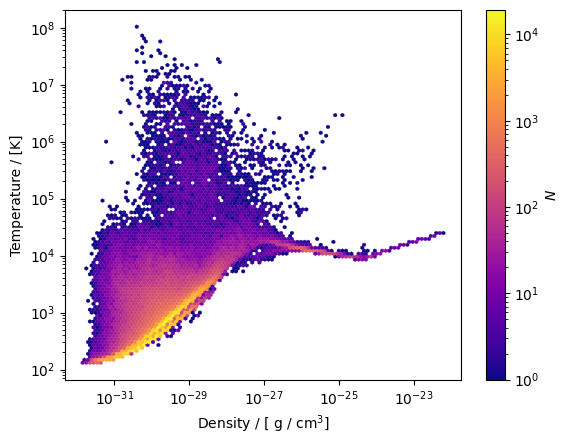

In [2]:
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract the temperatures and densities
hdf = h5py.File("../snapshots/EAGLE_6/snapshot_0002.hdf5", "r")
dens = hdf["PartType0/Densities"][:] * hdf["PartType0/Densities"].attrs["Conversion factor to physical CGS (including cosmological corrections)"]
temps = hdf["PartType0/Temperatures"][:]
hdf.close()

# See how we applied the correction to physical cgs to the density stored in the SWIFT snapshot. Simple!

# Plot the phase diagram
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.hexbin(dens, temps, mincnt=1, linewidths=0.2, cmap="plasma", xscale="log", yscale="log", norm=LogNorm())
ax.set_xlabel("Density / [ g / cm$^3$]")
ax.set_ylabel("Temperature / [K]")
cbar = fig.colorbar(im)
cbar.set_label("$N$")
plt.show()
plt.close()

Can you plot a cosmic star formation rate density plot from the stars? (Make sure you're using the most recent snapshot, this plot will be aided by having run the simulation for a bit to get more snapshots.)

<details>
  <summary>HINT</summary>
The cosmic star formation rate density describes the star formation rate of the entire universe as a function of redshift. The birth scale factor of each star is stored under `"PartType4/BirthScaleFactors"`.
</details>

## Extracting structure

We now have a real cosmological simulation with all the bells and whistles but the only outputs we have are big arrays of numbers for every particle in the simulation. As already demonstrated you can compute things of interest from these arrays but really we want halos and galaxies. So, how do we go from a sea of particles to identified structures...

The answer is (drum roll please...) halo finders. There exist a myriad of structure/halo finders, each with their own strengths and weaknesses. Here we will use the simplest possible version: a spatial Friends-of-Friends (FOF) algorithm. 

This class of algorithms find all the neighbours of each particle and then marries all neighbour collections with particles in common. (If you care about the technical nomenclature we'll be use a union-find type algorithm for the marrying stage.) To find neighbours we need a neighbour definition, so what makes two particles neighbours? 

### The linking length

In a FOF any two particles are neighbours if they are separated by less than the "linking length" ($\ell$). For host halos (the size of halos corresponding to galaxy groups and clusters) this length is well-defined,
$$
\ell = 0.2 \bar{x},
$$
where $\bar{x}$ is again the mean inter-particle separation and the 0.2 corresponds to structures around 200 times the mean density of the Universe. We'll begin by defining this linking length and using `scipy` to construct a KD-Tree from the positions of dark matter particles. A KD-Tree is an efficient method for finding neighbours without computing the distance to all other particles for every particle.

In [3]:
import numpy as np
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree


# First let's read the dark matter positions and masses from the most recent snapshot (edit the file path to match yours)
hdf = h5py.File("../snapshots/EAGLE_6/snapshot_0002.hdf5", "r")
pos = hdf["PartType1/Coordinates"][:]
masses = hdf["PartType1/Masses"][:] * 10 ** 10
hdf.close()

# Calculate the mean interparticle separation
xbar = (1 / (cosmo.Om(0) * cosmo.critical_density(0) / masses[0] / u.Msun)) ** (1/3)

# Calculate the linking length
linkl = 0.2 * xbar.to(u.Mpc).value

print("linkl =", linkl)

# Construct the kd-tree
tree = cKDTree(pos)

linkl = 0.01254006433552355


With the linking length calculated and KD-Tree constructed all we have to do to find the dark matter halos is query the tree with the position of every dark matter particle. This will produce a list of lists where the list at index `j` holds the indices of all neighbours of particle `j`. **This may take a moment!**

In [4]:
n_inds = tree.query_ball_point(pos, r=linkl)

We can now combine each of these individual results such that each particle points to all its neighbours in an array. Again this may take a while. Single-threaded Python is not the ideal tool for this!

In [ ]:
# Define a dict to hold the halos
ini_halo_indices = np.full(pos.shape[0], set())

# Loop over particle entries
for j, parts in enumerate(n_inds):
    print(j, end="\r")
    
    # Skip neighbourless particles
    if len(parts) < 2:
        continue

    # Get the neighbouring particle's existing sets
    nbour_sets = ini_halo_indices[parts]

    # Combine the sets
    nbour_sets[0].union(*nbour_sets[1:])

    # Update the set with the current neighbours
    nbour_sets[0].update(set(parts))

    # Update the sets each particle points to
    ini_halo_indices[parts] = nbour_sets[0]

And with this array in hand we can now extract each individual halo and store each halo's particles in a dictionary to use later.

In [ ]:
# Now we have all particles related we can create the final halo arrays...
halo_indices = {}

# ... to do this we will associate the halos to the particle with the minimum index.
for j, parts in enumerate(ini_halo_indices):
    print(j, end="\r")
    
    # Skip neighbourless particles
    if len(parts) < 2:
        continue

    # Get the minimum particle 
    min_ind = min(parts)

    # Attach these particles to that key
    if min_ind in halo_indices:
        continue
    halo_indices[min_ind] = parts

We now have a dictionary of all the indices for each halo. Lets see how many halos we have!

In [ ]:
print("N_halo = ", len(halo_indices))

This is quite a few halos for such a small volume. In fact, we have made a fundamental error here. The minimum number of particles in a halo we have in the above is 2! That's not very well resolved! Best practice is to use a minimum number larger than 20. Here we will use 32 to match the original halo catalogue from EAGLE.

In [ ]:
# Loop over the halo catalogue removing halos below the minimum particle count, convert the values to arrays
# and let's make some nice sequential halo IDs while we are at it
halo_id = 0
keys = list(halo_indices.keys())
values = list(halo_indices.values())
for key, parts in zip(keys, values):
    
    del halo_indices[key]
    if len(parts) >= 32:
        halo_indices[halo_id] = np.array(list(parts))
        halo_id += 1

print("N_halo = ", halo_id)

# Define how many halos we have
nhalo = halo_id

That's much more reasonable! There was a lot of statistical nonsense in our catalogue before!

### Caveats

In reality, spatial FOFs perform fairly horribly. They're very good (due to their simplicity) for on-the-fly calculations which only need quick estimates of structure. The `--eagle` flag we used above also turns on SWIFT's spatial FOF for various calculations used in the physics model such as black hole seeding. However, they do not produce robust structures, they'll abundantly return statistical nonsense at the lowest masses while sometimes producing unbound and nonsensical structures at higher masses, particularly during mergers. 

Halo finders, even if they start with a spatial FOF initially, employ numerous methods to produce robust structures. They'll use unbinding steps to remove unbound particles, some refine in phase space using velocity information, and others use the matter field to construct spherical overdensities, and this is just for the host halo level. Subhalos, the halos which contain galaxies, are not well described by a single linking length. Halo finders instead use other methods to identify these within host halos, some in phase space iteratively or recursively, others by finding saddle points in the density field, and as always each approach has its foibles. What we have done (and will do later) is a GROSS simplification.

## Plotting dark matter halo properties

To actually plot the halo properties from the dictionary created above we can simply index the particle property arrays with the indices of the particles in each halo. For instance, to calculate the dark matter mass of each halo we can simply do the following.

In [ ]:
# Create array to store halo massses
dm_halo_ms = np.zeros(nhalo)

# Loop over halos calculating DM mass
for i in range(nhalo):
    dm_halo_ms[i] = np.sum(masses[halo_indices[i]])

Can you plot a halo mass function in the cell below from this array of masses?

<details>
  <summary>HINT</summary>
A halo mass function is just a volume normalised histogram of the masses. Often done in logspace rather than linear space.
</details>

## Linking in other particle types

To simply combine the other particle types into these halos we will just attach baryonic particles to their nearest dark matter particle (as long as it's within the linking length). Obviously this won't be a particularly robust definition but its good enough.

(Again remember to modify the file path)

In [ ]:
# Loop over our halos and construct the halo ID array
for i in range(nhalo):
    part_halo_ids[halo_indices[i]] = i

# Now all we have to do is load up the other particle positions, query the DM tree for the DM neighbours and assign their halo
hdf = h5py.File("../snapshots/EAGLE_6/snapshot_0002.hdf5", "r")
gas_pos = hdf["PartType0/Coordinates"][:]
star_pos = hdf["PartType4/Coordinates"][:]
bh_pos = hdf["PartType5/Coordinates"][:]
hdf.close()

# Query the tree (this looking for only 1 neighbour)
_, gas_inds = tree.query(gas_pos, k=1, distance_upper_bound=linkl)
_, star_inds = tree.query(star_pos, k=1, distance_upper_bound=linkl)
_, bh_inds = tree.query(bh_pos, k=1, distance_upper_bound=linkl)

# Finally we can make a new dictionary with all particle types
halo_catologue = {"DM": halo_indices, "Gas": {}, "Stars": {}, "Black Holes": {}}
for i, ind in enumerate(gas_inds):

    # Skip particles not in a halo
    if ind == tree.n:
        continue
        
    # Get the dark matter halo ID
    dm_halo_id = part_halo_ids[ind]

    # If it's a legit halo store it
    if dm_halo_id >= 0:
        halo_catologue["Gas"].setdefault(dm_halo_id, set()).update({i, })
        
for i, ind in enumerate(star_inds):
    
    # Skip particles not in a halo
    if ind == tree.n:
        continue
        
    # Get the dark matter halo ID
    dm_halo_id = part_halo_ids[ind]

    # If it's a legit halo store it
    dm_halo_id = part_halo_ids[ind]
    if dm_halo_id >= 0:
        halo_catologue["Stars"].setdefault(dm_halo_id, set()).update({i, })
        
for i, ind in enumerate(bh_inds):

    # Skip particles not in a halo
    if ind == tree.n:
        continue
        
    # Get the dark matter halo ID
    dm_halo_id = part_halo_ids[ind]

    # If it's a legit halo store it
    dm_halo_id = part_halo_ids[ind]
    if dm_halo_id >= 0:
        halo_catologue["Black Holes"].setdefault(dm_halo_id, set()).update({i, })

# And convert all entries to arrays making empty ones when they don't appear
for key in range(nhalo):
    if key in halo_catologue["Gas"]:
        halo_catologue["Gas"][key] = np.array(list(halo_catologue["Gas"][key]))
    else:
        halo_catologue["Gas"][key] = np.array([])
        
for key in range(nhalo):
    if key in halo_catologue["Stars"]:
        halo_catologue["Stars"][key] = np.array(list(halo_catologue["Stars"][key]))
    else:
        halo_catologue["Stars"][key] = np.array([])
        
for key in range(nhalo):
    if key in halo_catologue["Black Holes"]:
        halo_catologue["Black Holes"][key] = np.array(list(halo_catologue["Black Holes"][key]))
    else:
        halo_catologue["Black Holes"][key] = np.array([])


Once again we can now extract what ever particle properties we want using this catalogue of indices. Here is how we would calculate the stellar mass of each halo.

In [ ]:
# Get the stellar masses
hdf = h5py.File("../snapshots/EAGLE_6/snapshot_0002.hdf5", "r")
star_ms = hdf["PartType4/Masses"][:] * 10 ** 10
hdf.close()

# Create array to store halo massses
nhalo = halo_id
stellar_halo_ms = np.zeros(nhalo)

# Loop over halos calculating DM mass
for i in range(nhalo):
    if halo_catologue["Stars"][i].size > 0:
        stellar_halo_ms[i] = np.sum(star_ms[halo_catologue["Stars"][i]])

Now I've run out of ideas... What relations can you make with this catalogue? Can you plot a stellar mass-halo mass relation, the black hole-stellar mass relation? The star formation rate density function? Etc etc etc.

### Finding galaxies

If you want to find galaxies instead of host halos you can rerun the above halo finding process but redefine the linking length to be 0.1 $\bar{x}$. This corresponds to an 8 times increase density to 1600 times the mean density of the Universe and is a good rough start to defining galaxies with a spatial FOF.